In [2]:
import requests
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

# Data Cleaning

Reading in the dataframes and concatenating into one:

In [3]:
st = pd.read_csv('./data/startrek2000.csv')

In [4]:
SW = pd.read_csv('./data/StarWars2000.csv')

In [5]:
sub_r = pd.concat([st, SW])

Let's review all 80+ columns to determine which ones to keep:

In [6]:
# disabling max colums to show in head() to review all columns
pd.options.display.max_columns = None
sub_r.head(1)  # reviewing all columns

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,thumbnail_height,thumbnail_width,url_overridden_by_dest,media,media_embed,removed_by_category,secure_media,secure_media_embed,edited,author_flair_background_color,author_flair_text_color,gilded,link_flair_template_id,link_flair_text,banned_by,author_cakeday,distinguished,author_flair_template_id,content_categories,gallery_data,is_gallery,link_flair_css_class,media_metadata,crosspost_parent,crosspost_parent_list,category
0,0,[],False,mrthomassamuel,NaN,[],NaN,text,t2_5o9c5jst,False,False,[],False,False,1615251974,self.startrek,https://www.reddit.com/r/startrek/comments/m0v...,{},m0v2qu,True,False,False,False,True,True,False,NaN,[],dark,text,False,False,True,0,0,False,all_ads,/r/startrek/comments/m0v2qu/star_trek_history/,False,self,"{'enabled': False, 'images': [{'id': 'S5rXqzW2...",6,1615251985,1,Below is the link to a superb video on the his...,True,False,False,startrek,t5_2qixm,279810,public,self,Star Trek History.,0,[],1.0,https://www.reddit.com/r/startrek/comments/m0v...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The only ones needed for our analysis are: 'subreddit', 'selftext' (description), and 'title'.

In [7]:
sub_r = sub_r[['subreddit', 'title', 'selftext']]
sub_r.tail()

,subreddit,title,selftext
1995,StarWars,can someone please tell me why my polls get au...,[removed]
1996,StarWars,poll,[removed]\n\n[View Poll](https://www.reddit.co...
1997,StarWars,Hardest poll,[removed]\n\n[View Poll](https://www.reddit.co...
1998,StarWars,Firing Gina Carano!,NaN
1999,StarWars,Bebe Eoda (The Mandalorian S2 Spoiler),NaN


Let's check for nulls:

In [8]:
sub_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4000 non-null   object
 1   title      4000 non-null   object
 2   selftext   2506 non-null   object
dtypes: object(3)
memory usage: 125.0+ KB


'selftext' has 1494 nulls. At first, drop null values was applied to this process, but that left not enough data to train our model well (72% accuracy score), so the decision was made to concentrate on title only since it was giving better results. 

In [9]:
sub_r = sub_r.drop('selftext', axis=1)

In [10]:
sub_r['title'].sort_values(ascending=False).tail(20)

643     "The universe is balanced on the back of a gia...
639     "Popular Space Show"- short and accurate TNG p...
663     "Please state the nature of the medical emerge...
1205                               "Now ONE, MORE, TIME!"
1508                                          "No capes!"
183     "Lower Decks" airing on Comedy Central Wed. night
1453    "It's unethical to harm a patient. I can infli...
1461    "It is a historical irony that Zefram Cochrane...
1410    "I lost a brother once. I was lucky I got him ...
317     "I don't believe in chance." • Fanart of one o...
1884                                "Hooked on a Klingon"
1143    "Hold their heads!!!" - Crusher really did mor...
149                          "He must live!" by Eli Hyder
1519               "Enterprise" doesn't get enough credit
164     "Chain of Comman" is some of the best TV ever ...
66      "CHOPPER!!! NO...!!!" [Please checkout more of...
1993              "Boba Returns" by Samuel Warrne Johnson
1240    "Behin

Above step helped identify rows with missing values as space. They will be removed by their index value.

In [11]:
sub_r.drop(index=[207], inplace=True)

In [12]:
sub_r.drop(index=[1298], inplace=True)

In [13]:
sub_r.drop(index=[1425], inplace=True)

In [14]:
sub_r.drop(index=[1594], inplace=True)

In [15]:
sub_r.drop(index=[1429], inplace=True)

In [16]:
sub_r.drop(index=[1087], inplace=True)

In [17]:
sub_r.drop(index=[1026], inplace=True)

In [18]:
sub_r.drop(index=[267], inplace=True)

In [19]:
sub_r.drop(index=[816], inplace=True)

In [20]:
sub_r.drop(index=[1788], inplace=True)

In [21]:
sub_r.drop(index=[441], inplace=True)

In [22]:
sub_r.shape

(3978, 2)

After initial Data Cleaning of 4000 entries we are left with 3978 rows. This is enough data for our model to work. 

# Pre-processing

Getting rid of emojis:

In [23]:
# found at https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [24]:
sub_r['title'] = sub_r.apply(lambda row: remove_emoji(row['title']), axis=1)

Since the model will guess whether the text came from Star Wars or Star Trek, let's remove the combination "STAR TREK" and "STAR WARS" from the posts and leave words "star", "wars" and "trek". Depending on the results of the model, this step might need another look:

In [25]:
sub_r['title'] = sub_r.title.map(lambda x: re.sub(
    '(Star Trek|Star Wars)[s]?', ' ', x, flags=re.I))

Noticed some URLs in some of the rows. This will remove them:

In [26]:
sub_r['title'] = sub_r['title'].apply(
    lambda x: re.split('https:\/\/.*', str(x))[0])

Let's tokenize the Title column:

In [27]:
tokenizer = RegexpTokenizer('[A-z]\w+')

In [28]:
sub_r['title_tok'] = sub_r.apply(
    lambda row: tokenizer.tokenize(row['title']), axis=1)

## Lemmatizing words

In [29]:
lemmatizer = WordNetLemmatizer()

In [30]:
# function to lemmatize words in tokenized sentence (list)
def sent_lemma(sent_tokenized):
    sent_lemma = [lemmatizer.lemmatize(token) for token in sent_tokenized]
    return sent_lemma

In [31]:
# going through the column:
sub_r['title_tok'] = [sent_lemma(i) for i in sub_r['title_tok']]

Now, let's come up with a modified list of stop words for this specific scenario. Might be handy to come back to this list later on:

In [32]:
stoplist = nltk.corpus.stopwords.words('english')
newStopWords = ['good', 'will', 'now', 'see']
stoplist.extend(newStopWords)

Adding a column to convert subreddit names to binary values:

In [33]:
sub_r['is_SW'] = (sub_r['subreddit'] == 'StarWars').astype(int)

# Initial EDA

Let's see what the word cloud would look like before any cleaning is applied:

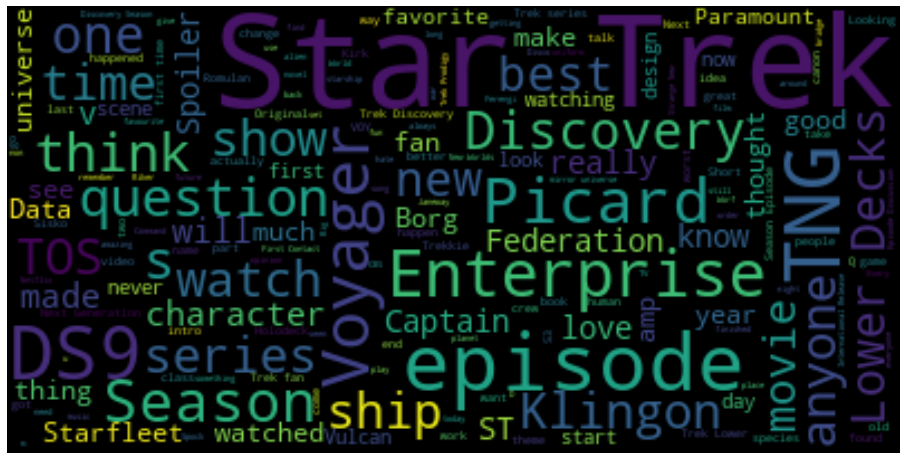

In [34]:
# from https://www.datacamp.com/community/tutorials/wordcloud-python

# Text of a column to use
text = st["title"].str.cat(sep=" ")

# Create and generate a word cloud:
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

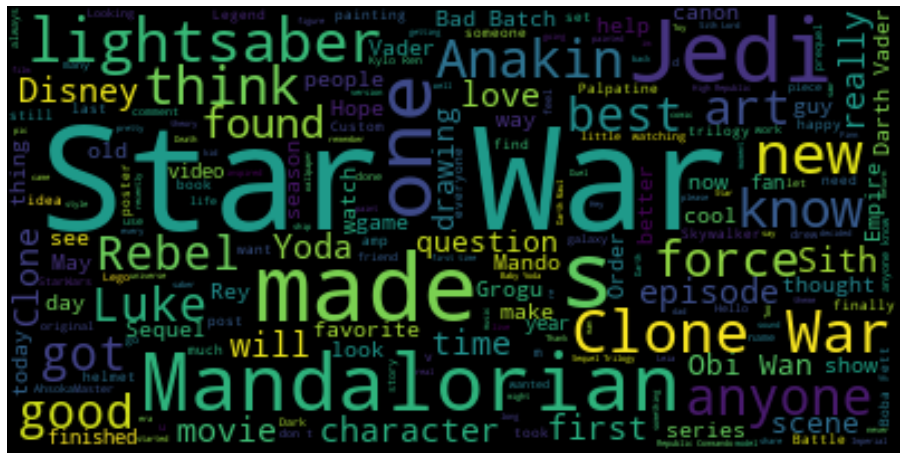

In [35]:
# Text of a column to use
text = SW["title"].str.cat(sep=" ")

# Create and generate a word cloud:
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Looks like the default stopwords() parameter did a good job removing them. An interesting observation is that 'episode', 'series', 'good', 'best', 'movie', 'favorite' are significant in both sets. We may take a look later in EDA if these words show up as shared among the subreddits and how it affects the model.

Let's look at word counts and character counts to determine potential differences between subreddits:

In [36]:
sub_r['title_char_c'] = sub_r['title'].map(len)

In [37]:
sub_r['title_word_c'] = sub_r['title'].map(lambda x: len(x.split()))

In [38]:
# for title:
sub_r['title_char_c'].groupby(sub_r['subreddit']).describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
StarWars,1989.0,54.332831,46.435670,1.0,24.0,41.0,68.0,298.0
startrek,1989.0,57.182001,40.685735,3.0,31.0,48.0,71.0,303.0


Star Trek titles are a bit longer at 57 characters, compared to 54 in Star Wars. Also, if doing train-test splits we will not need to stratify as it seems that the empty 22 rows that were previously removed were split in half between the subreddits. 

In [39]:
sub_r['title_word_c'].groupby(sub_r['subreddit']).describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
StarWars,1989.0,9.918552,8.569247,1.0,4.0,7.0,13.0,61.0
startrek,1989.0,10.024635,7.397312,1.0,5.0,8.0,13.0,60.0


Same trends in title word count.

Star Trek fans are leaving much longer posts than Star Wars users.

In [40]:
import seaborn as sns

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


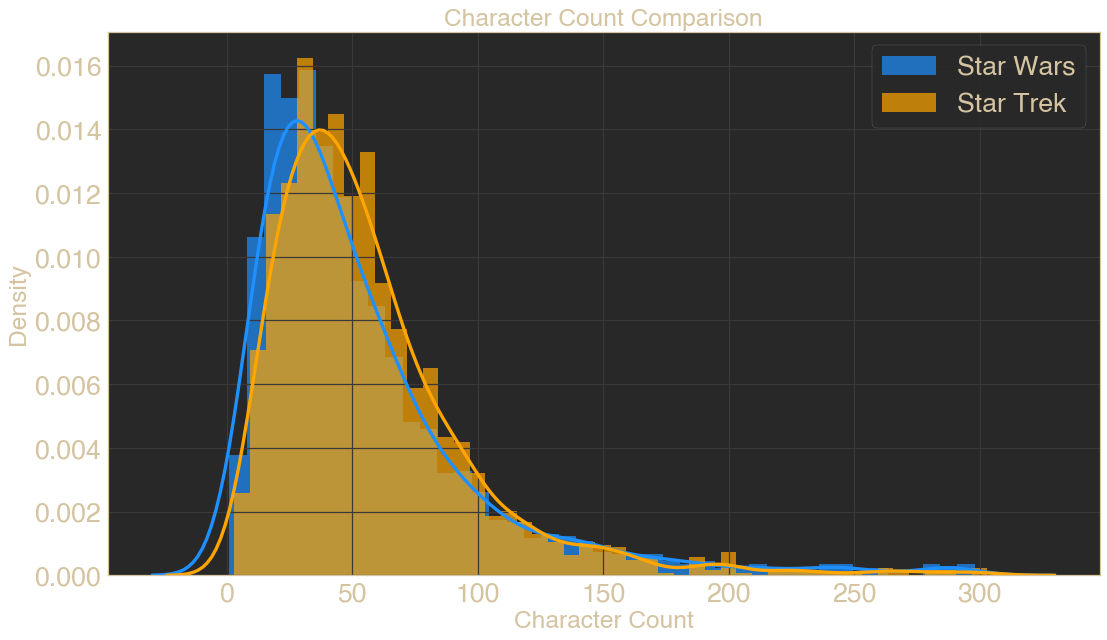

In [41]:
# Draw Plot
plt.figure(figsize=(16, 9), dpi=80)
sns.distplot(sub_r.loc[sub_r['subreddit'] == 'StarWars', 'title_char_c'],
             color="dodgerblue", label="Star Wars", hist_kws={'alpha': .7}, kde_kws={'linewidth': 3})
sns.distplot(sub_r.loc[sub_r['subreddit'] == 'startrek', 'title_char_c'],
             color="orange", label="Star Trek", hist_kws={'alpha': .7}, kde_kws={'linewidth': 3})

# Decoration
plt.title('Character Count Comparison', fontsize=22)
plt.xlabel("Character Count", fontsize=22)
plt.ylabel('Density', fontsize=22)
plt.legend(fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

Same graph, but side-by-side using matplotlib:

Now, word count:

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


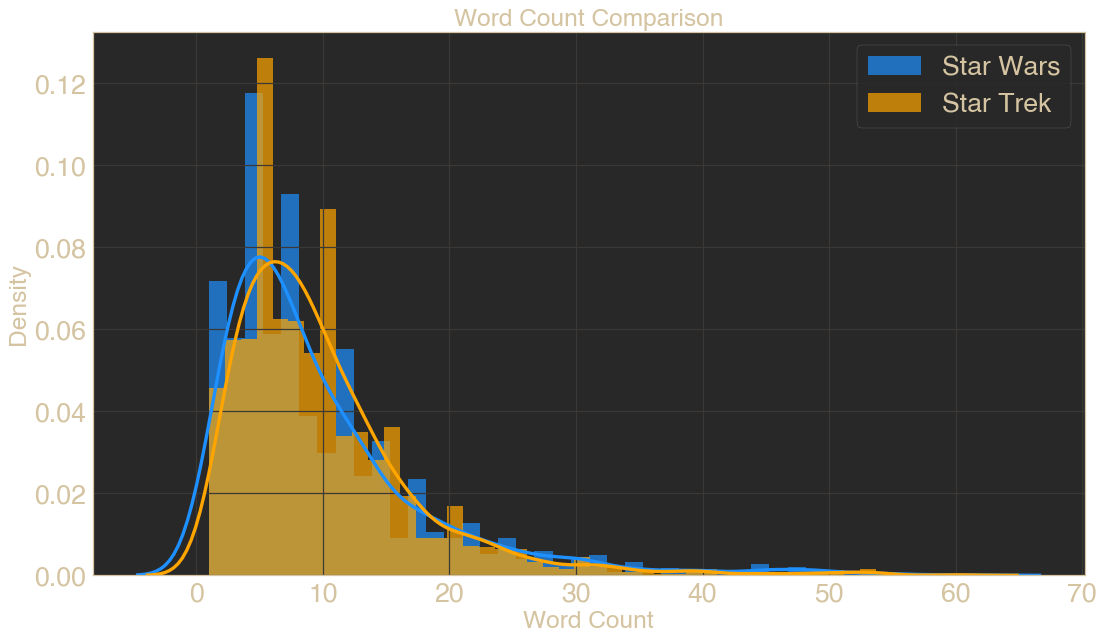

In [42]:
# Draw Plot
plt.figure(figsize=(16, 9), dpi=80)
sns.distplot(sub_r.loc[sub_r['subreddit'] == 'StarWars', 'title_word_c'],
             color="dodgerblue", label="Star Wars", hist_kws={'alpha': .7}, kde_kws={'linewidth': 3})
sns.distplot(sub_r.loc[sub_r['subreddit'] == 'startrek', 'title_word_c'],
             color="orange", label="Star Trek", hist_kws={'alpha': .7}, kde_kws={'linewidth': 3})

# Decoration
plt.title('Word Count Comparison', fontsize=22)
plt.xlabel("Word Count", fontsize=22)
plt.ylabel('Density', fontsize=22)
plt.legend(fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

We need to vectorize in order to perform additional EDA.

In [43]:
sub_r.head()

,subreddit,title,title_tok,is_SW,title_char_c,title_word_c
0,startrek,History.,[History],0,10,1
1,startrek,Picard's Michael Chabon on Romulan Romance D...,"[Picard, Michael, Chabon, on, Romulan, Romance...",0,52,7
2,startrek,Watching TNG how it was meant to be watched On...,"[Watching, TNG, how, it, wa, meant, to, be, wa...",0,78,16
3,startrek,What is your favourite episode/episode set (wh...,"[What, is, your, favourite, episode, episode, ...",0,65,9
4,startrek,voyager amv.,"[voyager, amv]",0,14,2


In [44]:
cvec = CountVectorizer(stop_words=stoplist, min_df=5, max_df=.95)

In [45]:
word_vectors_selftext = cvec.fit_transform(sub_r['title'])

In [46]:
len(cvec.get_feature_names())

976

In [47]:
word_vectors_df = pd.DataFrame(
    word_vectors_selftext.todense(), columns=cvec.get_feature_names())

In [48]:
word_vectors_df['sub_red'] = sub_r['subreddit'].reset_index(drop=True)

## Top 20 words in each subreddit

In [49]:
sums = word_vectors_df.groupby('sub_red').sum().T

In [51]:
sums_sw = pd.DataFrame(sums['StarWars'].sort_values(ascending=False).head(25))

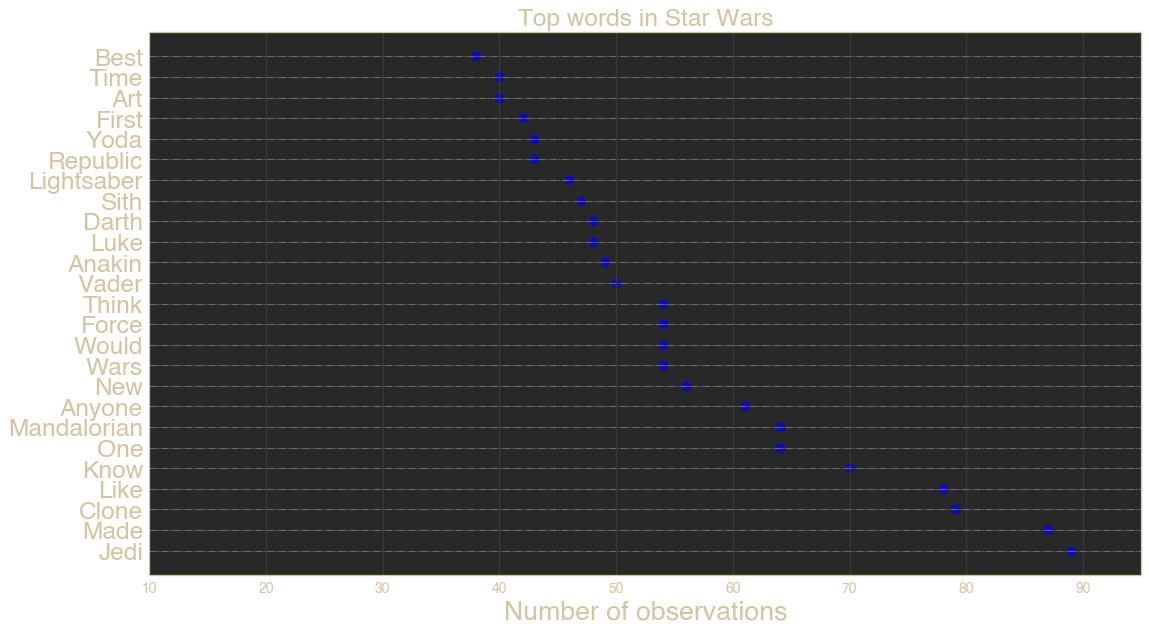

In [56]:
# Draw plot
fig, ax = plt.subplots(figsize=(16, 9), dpi=80)
ax.hlines(y=sums_sw.index, xmin=10, xmax=100, color='gray',
          alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=sums_sw.index, x=sums_sw.StarWars, s=75, color='blue', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Top words in Star Wars', fontdict={'size': 22})
ax.set_xlabel('Number of observations', fontsize=24)
ax.set_yticks(sums_sw.index)
ax.set_yticklabels(sums_sw.index.str.title(), fontsize= 22, fontdict={
                   'horizontalalignment': 'right'})
ax.set_xlim(10, 95)
plt.show()

In [57]:
sums_st = pd.DataFrame(sums['startrek'].sort_values(ascending=False).head(25))

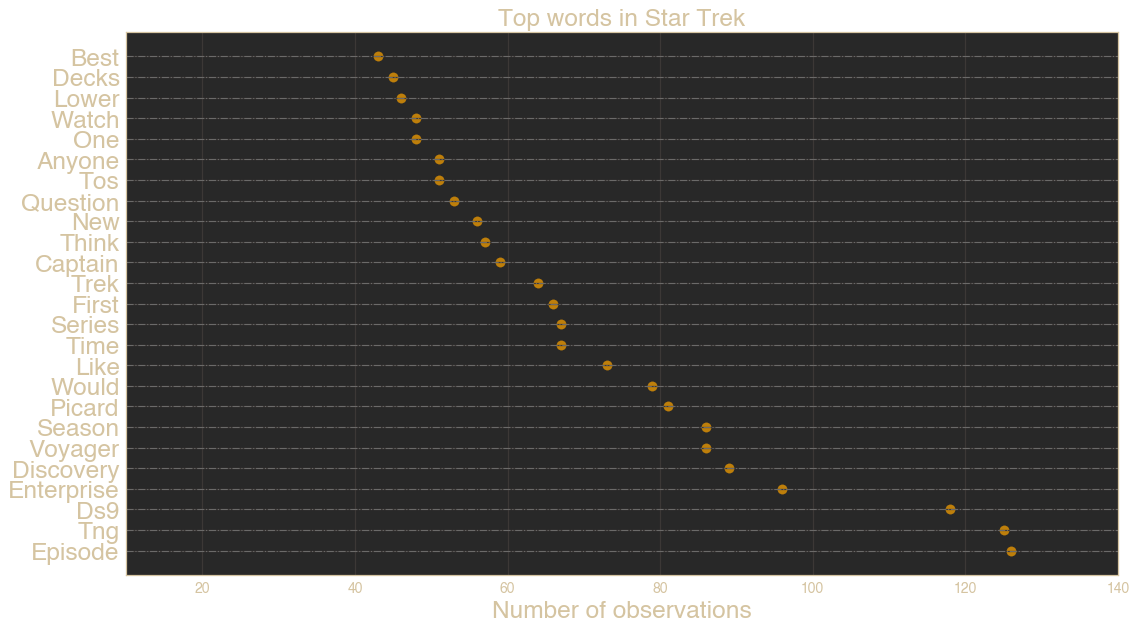

In [60]:
# Draw plot
fig, ax = plt.subplots(figsize=(16, 9), dpi=80)
ax.hlines(y=sums_st.index, xmin=10, xmax=140, color='gray',
          alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=sums_st.index, x=sums_st.startrek,
           s=75, color='orange', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Top words in Star Trek', fontdict={'size': 22})
ax.set_xlabel('Number of observations', fontsize=22)
ax.set_yticks(sums_st.index)
ax.set_yticklabels(sums_st.index.str.title(), fontsize=22, fontdict={
                   'horizontalalignment': 'right'})
ax.set_xlim(10, 140)
plt.show()

## Overlap words:

In [53]:
overlap_words = [i for i in sums_sw.index if i in sums_st.index]
overlap_words

['like', 'one', 'anyone', 'new', 'would', 'think', 'first', 'time', 'best']

The words overlap proves that the subreddits have different vocabularies as the common words in both of them are general terms that cannot identify a subreddit. This was done with 20 and 50 words.

# Modeling via Pipeline

In [54]:
X = sub_r['title']
y = sub_r['is_SW']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, train_size=0.66, stratify=y)

In [56]:
print(X_test.shape)
print(y_test.shape)

(1353,)
(1353,)


In [58]:
pipe_mnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

params_mnb = {
    'tvec__stop_words': [None, stoplist],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_df': [.85, .9, .95],
    'tvec__min_df': [2, 5, 10],
    'tvec__max_features': [1000, 2000, 3000],
}

gs_mnb = GridSearchCV(pipe_mnb, param_grid=params_mnb, cv=5)
gs_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.85, 0.9, 0.95],
                         'tvec__max_features': [1000, 2000, 3000],
                         'tvec__min_df': [2, 5, 10],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                 

In [59]:
print(f'best score is: {gs_mnb.best_score_}')

best score is: 0.8392380952380952


In [60]:
print(f'best parameters are: {gs_mnb.best_params_}')

best parameters are: {'tvec__max_df': 0.85, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'ho

In [82]:
tvec = TfidfVectorizer(max_df=0.85,
                       max_features=2000,
                       min_df=2,
                       ngram_range=(1, 1),
                       stop_words=stoplist)
X_train_tvec = tvec.fit_transform(X_train)
X_train_tvec = pd.DataFrame(X_train_tvec.toarray(),
                            columns=tvec.get_feature_names())
X_test_tvec = tvec.transform(X_test)
X_test_tvec = pd.DataFrame(X_test_tvec.toarray(),
                           columns=tvec.get_feature_names())
print('TfidfVectorizer:')
print(X_train_tvec.sum().sort_values(ascending=False)[:20])
print()

TfidfVectorizer:
episode        31.993198
like           31.029475
enterprise     29.333890
tng            28.777524
ds9            26.615127
first          25.188428
made           25.158584
time           24.786090
new            24.463624
discovery      24.249481
would          23.734417
think          23.148811
one            22.907689
question       22.857122
season         22.753710
series         22.065520
voyager        21.296302
mandalorian    21.199185
anyone         20.819686
jedi           20.207720
dtype: float64



In [83]:
mnb = MultinomialNB()

In [84]:
mnb.fit(X_train_tvec, y_train)

MultinomialNB()

In [85]:
y_pred_mnb = mnb.predict(X_test_tvec)

In [86]:
print(f'Train accuracy: {mnb.score(X_train_tvec, y_train)}')
print(f'Test accuracy: {mnb.score(X_test_tvec, y_test)}')

Train accuracy: 0.9356190476190476
Test accuracy: 0.8529194382852919


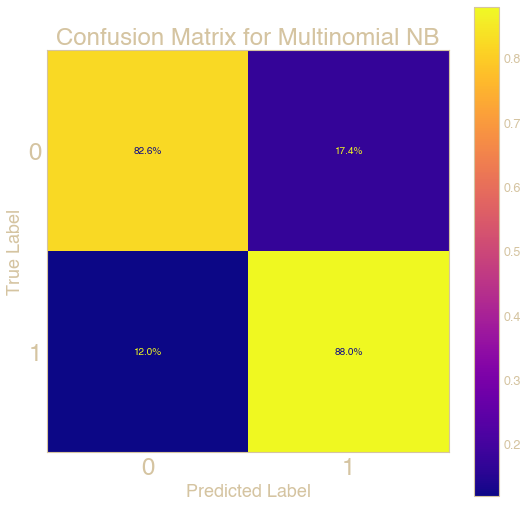

In [87]:
fig, ax = plt.subplots(figsize=(9, 9))
plot_confusion_matrix(mnb, X_test_tvec, y_test,
                      normalize='true',
                      ax=ax, cmap='plasma',
                      values_format='.1%')
plt.title('Confusion Matrix for Multinomial NB', fontsize=24)
plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(False)

The Multinimial Naive Bayes specificity is 82.6%. When the model predicted that the post is  from Star Trek, it got it right 82.6% of the time. Sensitivity came in at 88%. When the model predicted Star Wars as a subreddit, it got it correct 88% of the time.

## Random Forrest model pipeline

In [67]:
pipe_rf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

params_rf = {
    'tvec__stop_words': [None, stoplist],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__min_df': [2, 5, 10],
    'tvec__max_df': [.85, .9, .95],
    'tvec__max_features': [1000, 2000, 3000]
}

gs_rf = GridSearchCV(pipe_rf, param_grid=params_rf, cv=5)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'tvec__max_df': [0.85, 0.9, 0.95],
                         'tvec__max_features': [1000, 2000, 3000],
                         'tvec__min_df': [2, 5, 10],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
         

In [68]:
print(f'best score is: {gs_rf.best_score_}')

best score is: 0.8129523809523811


In [69]:
print(f'best parameters are: {gs_rf.best_params_}')

best parameters are: {'tvec__max_df': 0.85, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'ho

In [76]:
tvec = TfidfVectorizer(max_df=0.85,
                       max_features=3000,
                       min_df=2,
                       ngram_range=(1, 2),
                       stop_words=stoplist)
X_train_tvec = tvec.fit_transform(X_train)
X_train_tvec = pd.DataFrame(X_train_tvec.toarray(),
                            columns=tvec.get_feature_names())
X_test_tvec = tvec.transform(X_test)
X_test_tvec = pd.DataFrame(X_test_tvec.toarray(),
                           columns=tvec.get_feature_names())
print('TfidfVectorizer:')
print(X_train_tvec.sum().sort_values(ascending=False)[:20])
print()

TfidfVectorizer:
episode        27.478630
like           27.371665
enterprise     27.303796
tng            26.088179
ds9            24.639614
made           22.798791
discovery      22.691263
new            22.236164
time           21.856312
would          21.057997
think          21.020209
first          20.988195
one            20.972783
question       20.872102
voyager        20.002155
mandalorian    19.557700
series         19.478528
season         19.278415
jedi           18.435734
anyone         18.088873
dtype: float64



In [77]:
rf = RandomForestClassifier()

In [78]:
rf.fit(X_train_tvec, y_train)

RandomForestClassifier()

In [79]:
y_pred_rf = rf.predict(X_test_tvec)

In [80]:
print(f'Train accuracy: {rf.score(X_train_tvec, y_train)}')
print(f'Test accuracy: {rf.score(X_test_tvec, y_test)}')

Train accuracy: 0.9847619047619047
Test accuracy: 0.8144863266814486


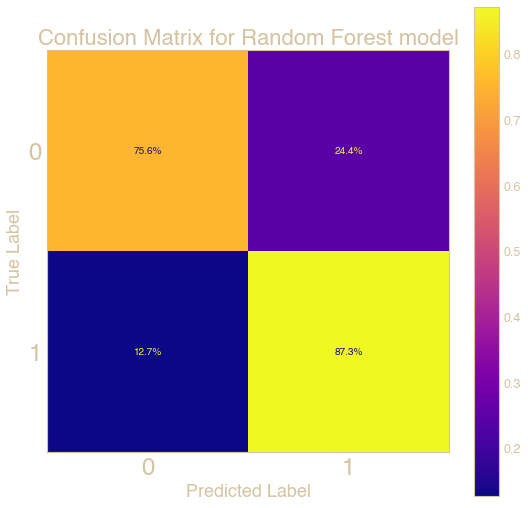

In [81]:
fig, ax = plt.subplots(figsize=(9, 9))
plot_confusion_matrix(rf, X_test_tvec, y_test,
                      normalize='true',
                      ax=ax, cmap='plasma',
                      values_format='.1%')
plt.title('Confusion Matrix for Random Forest model', fontsize=22)
plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(False)

| Model          | Training Score | Testing Score | Specificity | Sensitivity |
|----------------|----------------|---------------|----------------------|---------------|
| Multinomial NB | 93.6           | 85.3          | 82.6%               | 88.0%         |
| Random Forest  | 98.5           | 81.4          | 75.6%                  | 87.3%           |

In conclusion, the Multinomial Naive Bayes performed better than Random Forrest model. The MNB model achieved test accuracy score of 85.3 comapred to 81.4 via Random Forest. Both models are still slightly overfit, but the difference between train and test scores is smaller in MNB model.

# Conclusions and Recommendations

In [192]:
# from https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
st_class_prob_sorted = mnb.feature_log_prob_[0, :].argsort()
SW_class_prob_sorted = mnb.feature_log_prob_[1, :].argsort()

st_terms = np.take(tvec.get_feature_names(), st_class_prob_sorted[-25:])
SW_terms = np.take(tvec.get_feature_names(), SW_class_prob_sorted[-25:])

st_odds = mnb.feature_log_prob_[0, :][-25:]
SW_odds = mnb.feature_log_prob_[1, :][-25:]

The coef_ attribute of MultinomialNB is a re-parameterization of the naive Bayes model as a linear classifier model. This is basically the log of the estimated probability of a feature given the positive class - Star Wars. Higher coef_ values mean more important features for the positive class.

Let's put the terms and their coefficients into dataframes:

In [194]:
st_coef = pd.DataFrame(
    {'term': st_terms,
     'coef': list(st_odds)
     })
st_coef = st_coef.sort_values(['coef'])

In [195]:
st_coef

,term,coef
24,enterprise,-8.437775
17,question,-8.437775
21,episode,-8.437775
9,captain,-8.437775
15,picard,-8.103929
2,lower,-7.968738
13,like,-7.955092
19,voyager,-7.930220
18,season,-7.888594
3,starfleet,-7.876297


In [203]:
SW_coef = pd.DataFrame(
    {'term': SW_terms,
     'coef': list(SW_odds)
     })
SW_coef = SW_coef.sort_values(['coef'])

In [204]:
SW_coef

,term,coef
22,made,-8.424817
3,first,-8.424817
4,way,-8.424817
5,anyone,-8.424817
23,jedi,-8.424817
19,like,-8.198181
7,got,-8.112368
16,vader,-8.039642
2,trilogy,-7.890017
15,know,-7.778966


And plot them:

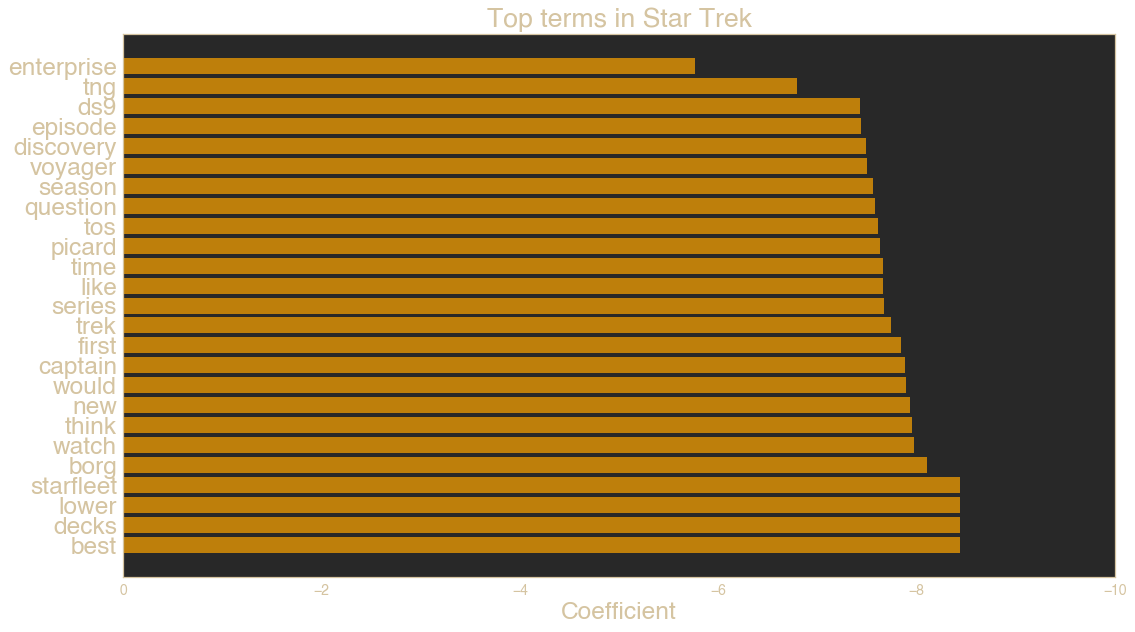

In [201]:
# Draw plot
fig, ax = plt.subplots(figsize=(16, 9), dpi=80)
ax.barh(st_coef.term, st_coef.coef, color='orange', alpha=0.7)
ax.hlines(y=st_coef.index, xmin=10, xmax=30, color='gray',
          alpha=0.7, linewidth=1, linestyles='dashdot')
ax.grid(False)

# Title, Label, Ticks and Ylim
ax.set_title('Top terms in Star Trek', fontdict={'size': 24})
ax.set_xlabel('Coefficient', fontsize=22)
ax.set_yticks(st_coef.index)
ax.set_yticklabels(st_coef.term, fontdict={
                   'horizontalalignment': 'right'}, fontsize=22)
ax.set_xlim(0, -10)
plt.show()

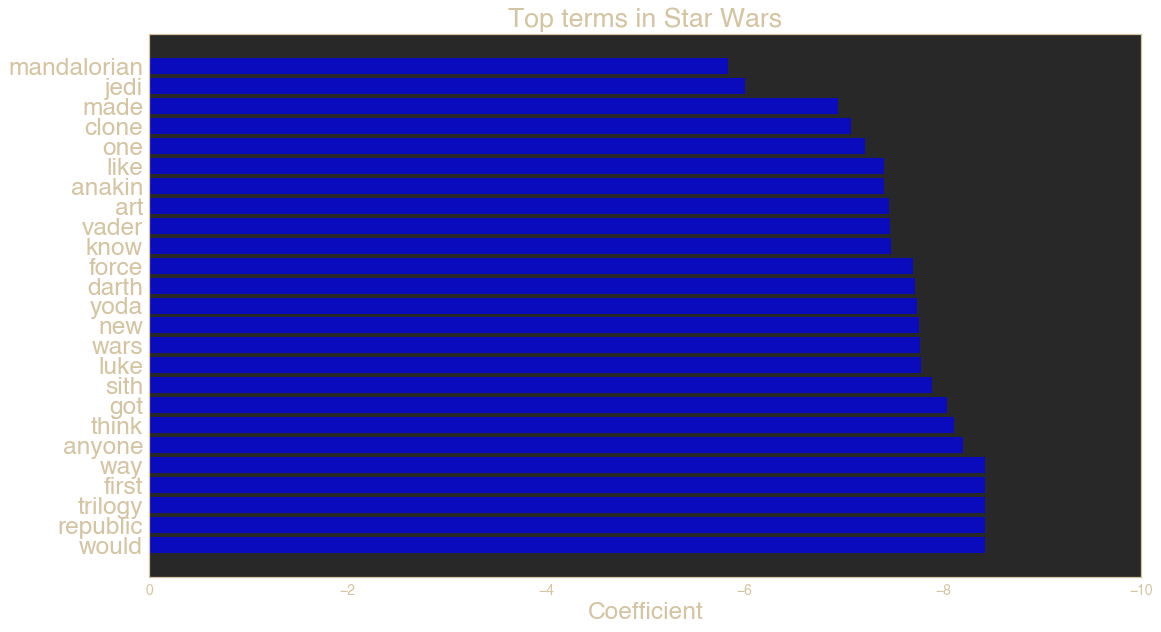

In [205]:
# Draw plot
fig, ax = plt.subplots(figsize=(16, 9), dpi=80)
ax.barh(SW_coef.term, SW_coef.coef, color='blue', alpha=0.7)
ax.hlines(y=SW_coef.index, xmin=10, xmax=30, color='gray',
          alpha=0.7, linewidth=1, linestyles='dashdot')
ax.grid(False)

# Title, Label, Ticks and Ylim
ax.set_title('Top terms in Star Wars', fontdict={'size': 24})
ax.set_xlabel('Coefficient', fontsize=22)
ax.set_yticks(SW_coef.index)
ax.set_yticklabels(SW_coef.term, fontdict={
                   'horizontalalignment': 'right'}, fontsize=22)
ax.set_xlim(0, -10)
plt.show()

Now let's do the same for bottom words with smallest coefficients:

In [206]:
st_terms_b = np.take(tvec.get_feature_names(), st_class_prob_sorted[:25])
SW_terms_b = np.take(tvec.get_feature_names(), SW_class_prob_sorted[:25])

st_odds_b = mnb.feature_log_prob_[0, :][:25]
SW_odds_b = mnb.feature_log_prob_[1, :][:25]

In [207]:
st_coef_b = pd.DataFrame(
    {'term': st_terms_b,
     'coef': list(st_odds_b)
     })
st_coef_b = st_coef_b.sort_values(['coef'])

In [208]:
st_coef_b

,term,coef
12,less,-8.437775
2,chewbacca,-8.437775
21,lord,-8.437775
6,leads,-8.437775
13,lighsaber,-8.437775
23,lucas,-8.437775
10,leia,-8.437775
17,liked,-8.178611
11,charcoal,-8.036844
22,loves,-7.939351


In [209]:
SW_coef_b = pd.DataFrame(
    {'term': SW_terms_b,
     'coef': list(SW_odds_b)
     })
SW_coef_b = SW_coef_b.sort_values(['coef'])

In [210]:
SW_coef_b

,term,coef
0,01,-8.424817
22,georgiou,-8.424817
18,sisko,-8.424817
16,common,-8.424817
15,console,-8.424817
9,computer,-8.424817
24,comedy,-8.424817
5,phaser,-8.424817
7,confirmed,-8.120898
17,genesis,-8.068965


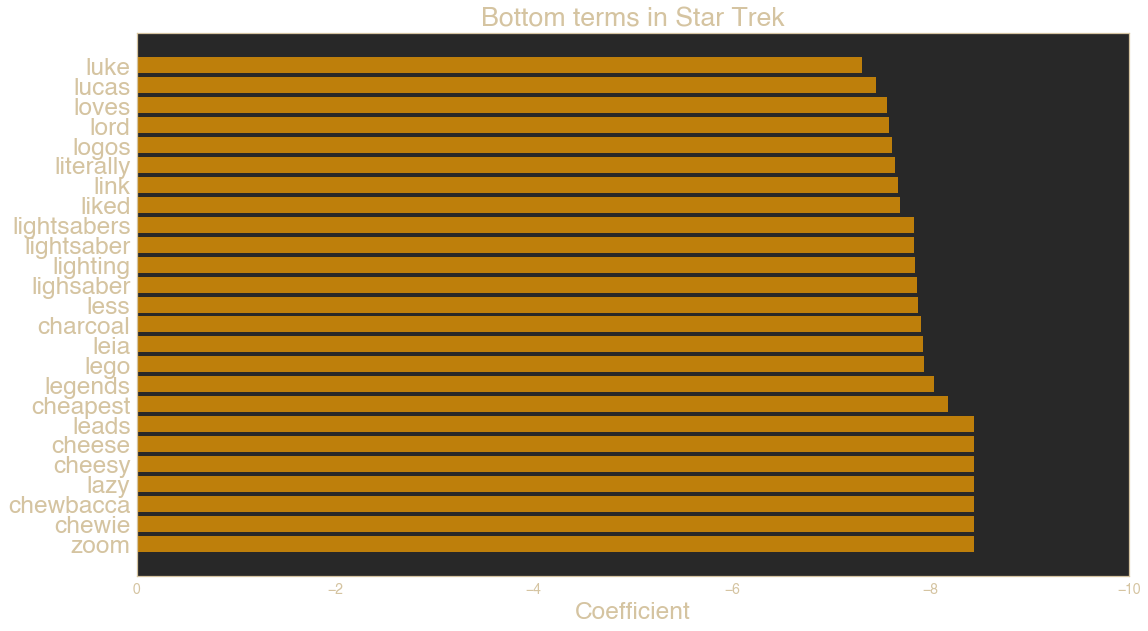

In [212]:
# Draw plot
fig, ax = plt.subplots(figsize=(16, 9), dpi=80)
ax.barh(st_coef_b.term, st_coef_b.coef, color='orange', alpha=0.7)
ax.hlines(y=st_coef_b.index, xmin=10, xmax=30, color='gray',
          alpha=0.7, linewidth=1, linestyles='dashdot')
ax.grid(False)

# Title, Label, Ticks and Ylim
ax.set_title('Bottom terms in Star Trek', fontdict={'size': 24})
ax.set_xlabel('Coefficient', fontsize=22)
ax.set_yticks(st_coef_b.index)
ax.set_yticklabels(st_coef_b.term, fontdict={
                   'horizontalalignment': 'right'}, fontsize=22)
ax.set_xlim(0, -10)
plt.show()

It is not a surprise to see some of the popular "themed" Star Wars terms on the bottom of this list.

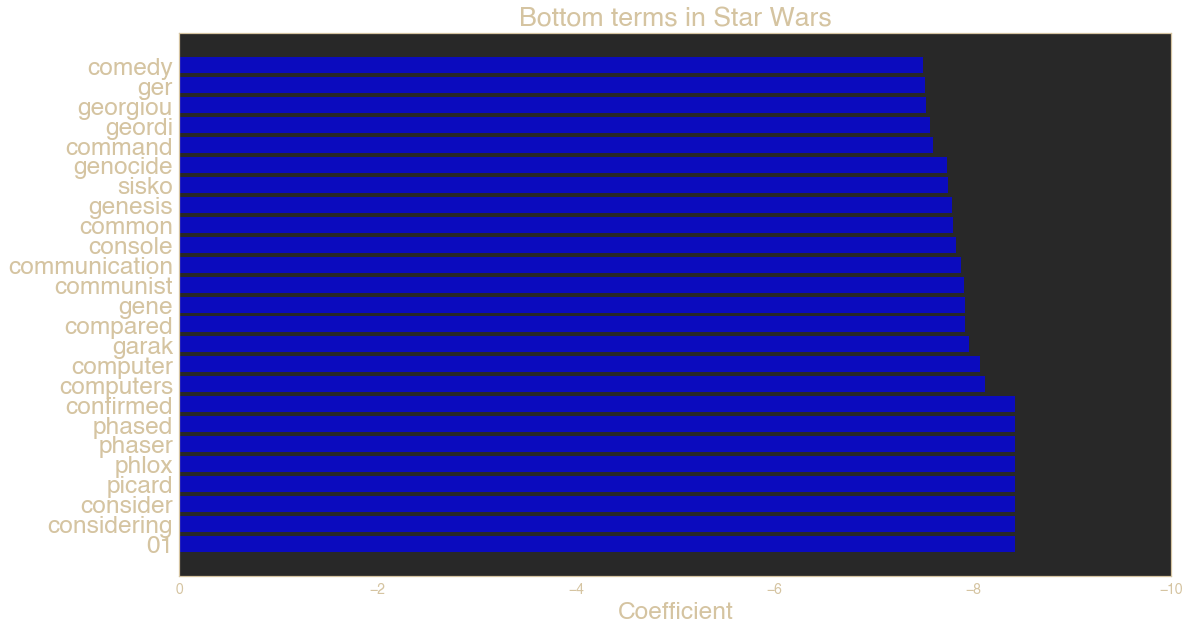

In [215]:
# Draw plot
fig, ax = plt.subplots(figsize=(16, 9), dpi=80)
ax.barh(SW_coef_b.term, SW_coef_b.coef, color='blue', alpha=0.7)
ax.hlines(y=SW_coef_b.index, xmin=10, xmax=30, color='gray',
          alpha=0.7, linewidth=1, linestyles='dashdot')
ax.grid(False)

# Title, Label, Ticks and Ylim
ax.set_title('Bottom terms in Star Wars', fontdict={'size': 24})
ax.set_xlabel('Coefficient', fontsize=22)
ax.set_yticks(SW_coef_b.index)
ax.set_yticklabels(SW_coef_b.term, fontdict={
                   'horizontalalignment': 'right'}, fontsize=22)
ax.set_xlim(0, -10)
plt.show()